# $C^{(kin)}(t=1;β1,β2)$ -- kinetic cost for PWC[2] over [0,1/2] - $\beta_1$ and [1/2,1] $\beta_2$ inervals

[baseline iso-level] const β0=2 -> J_kin=0.732886
[adaptive] sampled points: 2700


/var/folders/s5/8pby83n5305c0l0dvb7d7p5c0000gr/T/ipykernel_4636/1887409798.py:206: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for coll in CS.collections:


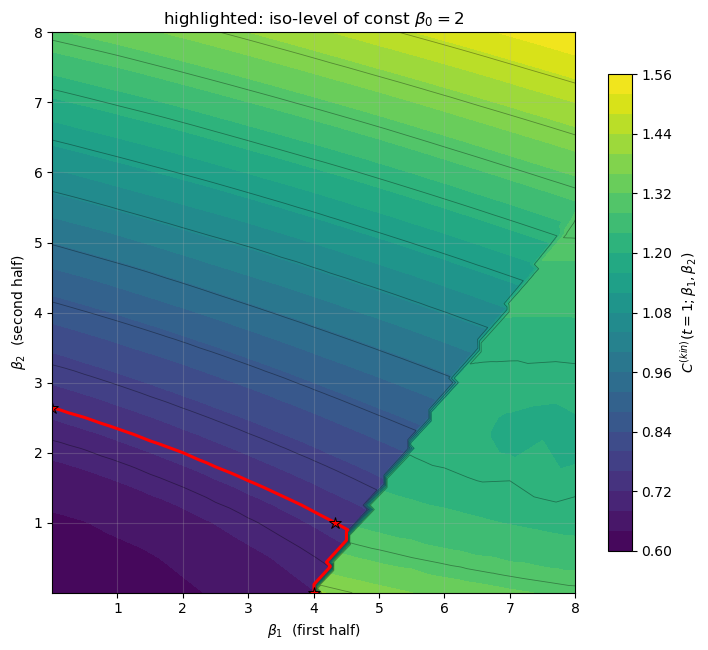

[saved] figs/adaptive_isocostKIN_colormap_iso_beta0_2.png
[iso points] β-pairs: [(0.001, 2.642911836044355), (4.009838954080525, 0.001), (4.327741911966484, 1.000875)]


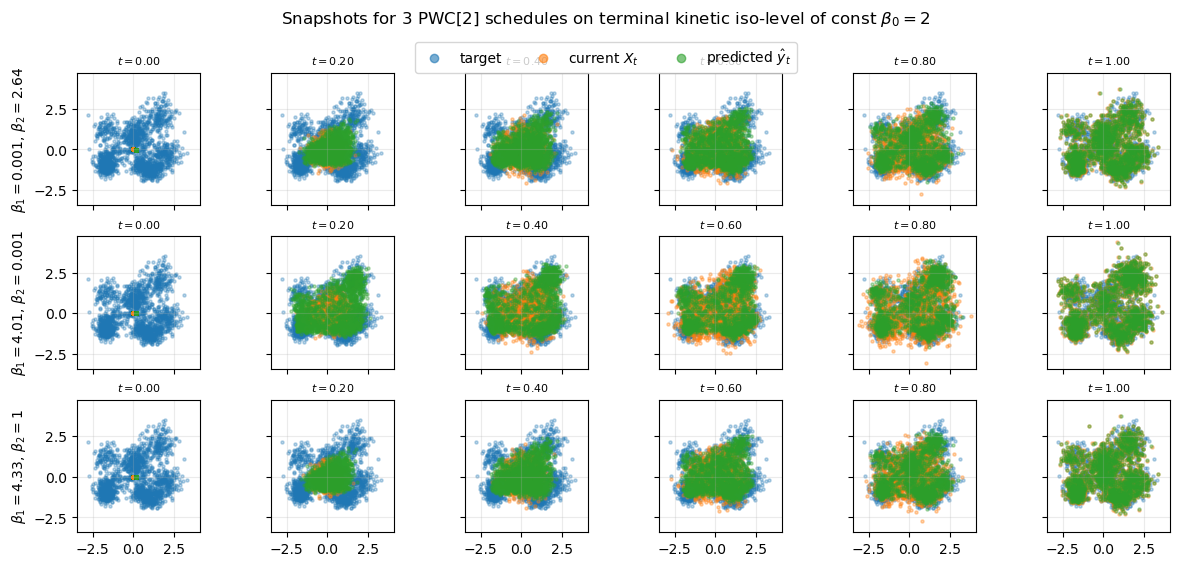

[saved] figs/adaptive_isocostKIN_snapshots_iso_beta0_2.png


In [6]:
import sys
from ada_api_clean import *

# =====================================================================
# Adaptive iso-cost (KINETIC ONLY) for PWC[2] β(t) on Perturbed-A GMM
#   • Target reset to "Perturbed A" (deterministic seed)
#   • Objective: C^{(kin)}(t=1;β1,β2) (midpoint EM, x(0)=0)
#   • PWC[2]: β(t)=β1 on [0, 1/2), β2 on [1/2, 1]
#   • Adaptive quadtree refinement on [B_MIN,B_MAX]^2
#   • Single colormap (tricontourf) + level sets; emphasize iso-level of const β0=2
#   • Pick 3 representative points on the iso-level: min β1, min β2, and mid-arc
#   • Build snapshot mega-figure for those 3 schedules (rows) × time (cols)
# =====================================================================
import numpy as np, math, os
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

os.makedirs("figs", exist_ok=True)

# -------------------- 1) Target reset: Perturbed A --------------------
gmm=pertA
# -------------------- 2) Schedule helpers --------------------
EDGES = np.array([0.0, 0.5, 1.0], float)

def build_pwc_schedule(edges, betas):
    edges = np.asarray(edges, float)
    betas = np.asarray(betas, float)
    assert len(edges) == len(betas) + 1
    assert np.all(np.diff(edges) > 0)
    tried = []
    try:
        s = BetaSchedulePWC.PWC(splits=edges, betas=betas)
        for tp in (0.25, 0.75):
            a,K,g = alpha_K_gamma_from_schedule(s, float(tp))
            assert np.isfinite(a) and np.isfinite(K) and (K>0) and np.isfinite(g) and (g>0)
        return s
    except Exception as e:
        tried.append("BetaSchedulePWC.PWC: " + repr(e))
    try:
        s = BetaSchedulePWC(betas=betas, splits=edges)
        for tp in (0.25, 0.75):
            a,K,g = alpha_K_gamma_from_schedule(s, float(tp))
            assert np.isfinite(a) and np.isfinite(K) and (K>0) and np.isfinite(g) and (g>0)
        return s
    except Exception as e:
        tried.append("BetaSchedulePWC(...): " + repr(e))
    try:
        s = BetaSchedulePWC.piecewise_constant(splits=edges, betas=betas)
        for tp in (0.25, 0.75):
            a,K,g = alpha_K_gamma_from_schedule(s, float(tp))
            assert np.isfinite(a) and np.isfinite(K) and (K>0) and np.isfinite(g) and (g>0)
        return s
    except Exception as e:
        tried.append("BetaSchedulePWC.piecewise_constant: " + repr(e))
    raise RuntimeError("Could not construct PWC schedule:\n  - " + "\n  - ".join(tried))

def pwc2_schedule(beta1, beta2):
    return build_pwc_schedule(EDGES, np.array([float(beta1), float(beta2)], float))

def constant_schedule(beta):
    return BetaSchedulePWC.constant(float(beta))

# -------------------- 3) Kinetic-only cost with safe interior eval --------------------
def simulate_kinetic_cost_safe(sched, gmm, M=750, T=380, seed=0, t_floor=0.01):
    """
    Midpoint EM; X(0)=0; drift at t_eff ∈ [t_floor, 1-t_floor].
    Return J_kin = ∫ E ||u_t||^2 dt.
    """
    rng = np.random.default_rng(seed)
    dt  = 1.0 / T
    d   = gmm.d
    X   = np.zeros((M, d), float)
    acc = 0.0

    for n in range(T):
        t_mid = (n + 0.5) / T
        t_eff = float(min(max(t_mid, t_floor), 1.0 - t_floor))
        yhat  = yhat_oracle_gmm(X, t_eff, sched, gmm)
        a_m   = float(sched.a_minus(t_eff))
        b_m   = float(sched.b_minus(t_eff))
        u     = b_m*yhat - a_m*X
        acc  += float(np.mean(np.sum(u*u, axis=1)))*0.5

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return acc * dt

# -------------------- 4) Adaptive quadtree refinement --------------------
def _key(b1, b2, q=12):
    return (round(float(b1), q), round(float(b2), q))

def adaptive_sample_Jkin(
    B_MIN=1e-3, B_MAX=8.0,
    init_N=7, max_depth=3,
    tau_rel=0.06,            # relative tolerance for variation inside cell
    tau_abs_min=1e-3,        # absolute floor to avoid over-refining near 0
    M=750, T=380, seed=0, t_floor=0.01
):
    """
    Adaptive quadtree: subdivide a cell if (max corner J - min corner J) > τ,
    where τ = max(tau_rel * J_scale, tau_abs_min) and J_scale is updated online.
    Returns scattered (X,Y,J) arrays + a cache dict.
    """
    cache = {}
    Xs, Ys, Zs = [], [], []
    J_scale = [1.0]  # mutable scalar captured by closure

    def evalJ(b1, b2):
        k = _key(b1, b2)
        if k in cache:
            return cache[k]
        try:
            sch = pwc2_schedule(b1, b2)
            J  = simulate_kinetic_cost_safe(sch, gmm, M=M, T=T, seed=seed, t_floor=t_floor)
        except Exception:
            J = np.nan
        cache[k] = J
        if np.isfinite(J):
            J_scale[0] = max(J_scale[0], abs(J))
        return J

    def sample_point(b1,b2):
        J = evalJ(b1,b2)
        Xs.append(b1); Ys.append(b2); Zs.append(J)

    def refine(x0,x1,y0,y1, depth):
        # corners + center
        c = [
            (x0, y0), (x1, y0),
            (x0, y1), (x1, y1),
            ((x0+x1)/2.0, (y0+y1)/2.0)
        ]
        vals = [evalJ(b1,b2) for (b1,b2) in c]
        # add to scatter set
        for (b1,b2), J in zip(c, vals):
            if np.isfinite(J):
                sample_point(b1,b2)

        # refine criterion: variation across the 4 corners
        Jcorn = [vals[0], vals[1], vals[2], vals[3]]
        Jcorn_f = [v for v in Jcorn if np.isfinite(v)]
        if len(Jcorn_f) < 2:
            return
        var = max(Jcorn_f) - min(Jcorn_f)
        thresh = max(tau_rel * J_scale[0], tau_abs_min)
        if (var > thresh) and (depth < max_depth):
            xm = (x0+x1)/2.0; ym = (y0+y1)/2.0
            refine(x0, xm, y0, ym, depth+1)
            refine(xm, x1, y0, ym, depth+1)
            refine(x0, xm, ym, y1, depth+1)
            refine(xm, x1, ym, y1, depth+1)

    # initial tiling into init_N-1 by init_N-1 cells
    grid = np.linspace(B_MIN, B_MAX, init_N)
    for i in range(init_N-1):
        for j in range(init_N-1):
            refine(grid[i], grid[i+1], grid[j], grid[j+1], depth=0)

    X = np.asarray(Xs, float)
    Y = np.asarray(Ys, float)
    Z = np.asarray(Zs, float)
    mask = np.isfinite(Z)
    return X[mask], Y[mask], Z[mask], cache

# -------------------- 5) Baseline iso-level from constant β0=2 --------------------
beta0_iso   = 2.0
seed_isoCRN = 20241009  # CRN for the iso analysis

J0 = simulate_kinetic_cost_safe(constant_schedule(beta0_iso), gmm,
                                M=3000, T=500, seed=seed_isoCRN, t_floor=0.01)
print(f"[baseline iso-level] const β0={beta0_iso:g} -> J_kin={J0:.6g}")

# -------------------- 6) Run adaptive sampling --------------------
B_MIN, B_MAX = 1e-3, 8.0
X, Y, Z, cache = adaptive_sample_Jkin(
    B_MIN=B_MIN, B_MAX=B_MAX,
    init_N=9, max_depth=3, tau_rel=0.06, tau_abs_min=1e-3,
    M=3000, T=500, seed=seed_isoCRN, t_floor=0.01
)
print(f"[adaptive] sampled points: {len(X)}")

# -------------------- 7) Triangulate & plot tricontourf + iso-level --------------------
tri = mtri.Triangulation(X, Y)
levels_main = 28  # number of filled levels

fig, ax = plt.subplots(1,1, figsize=(7.3,6.6))
cf = ax.tricontourf(tri, Z, levels=levels_main, cmap="viridis")
cbar = fig.colorbar(cf, ax=ax, shrink=0.85)
cbar.set_label(r"$C^{(kin)}(t=1;\beta_1,\beta_2)$", rotation=90)

# Overlay level sets; emphasize J0 (const β=2) in thick line
CS_all = ax.tricontour(tri, Z, levels=np.linspace(np.nanmin(Z), np.nanmax(Z), 12),
                       colors="k", linewidths=0.6, alpha=0.35)
CS_iso = ax.tricontour(tri, Z, levels=[J0], colors="red", linewidths=2.2)

ax.set_xlim(B_MIN, B_MAX); ax.set_ylim(B_MIN, B_MAX)
ax.set_xlabel(r"$\beta_1$  (first half)"); ax.set_ylabel(r"$\beta_2$  (second half)")
ax.set_title(fr"highlighted: iso-level of const $\beta_0={beta0_iso:g}$")
ax.grid(True, alpha=0.25)

# -------------------- 8) Extract 3 representative points on the iso-level --------------------
def pick_three_on_isolevel(CS):
    # choose the longest segment among all paths
    segs = []
    for coll in CS.collections:
        for path in coll.get_paths():
            v = path.vertices
            if v.shape[0] >= 2:
                # total length
                d = np.sum(np.linalg.norm(v[1:] - v[:-1], axis=1))
                segs.append((d, v))
    if not segs:
        return None
    segs.sort(key=lambda x: x[0], reverse=True)
    V = segs[0][1]  # longest
    # pick min β1 point, min β2 point, and mid index
    i_min_b1 = int(np.argmin(V[:,0]))
    i_min_b2 = int(np.argmin(V[:,1]))
    i_mid    = V.shape[0] // 2
    pts = [tuple(V[i_min_b1]), tuple(V[i_min_b2]), tuple(V[i_mid])]
    # ensure distinctness (if duplicates, perturb by one index)
    uniq = []
    used = set()
    for p in pts:
        key = (round(p[0],6), round(p[1],6))
        if key in used:
            # find nearest alternate
            for offs in (-3,-2,-1,1,2,3):
                j = np.clip(i_mid+offs, 0, V.shape[0]-1)
                q = (float(V[j,0]), float(V[j,1]))
                qk = (round(q[0],6), round(q[1],6))
                if qk not in used:
                    used.add(qk); uniq.append(q); break
        else:
            used.add(key); uniq.append((float(p[0]), float(p[1])))
    return uniq

iso_points = pick_three_on_isolevel(CS_iso)

if iso_points is None:
    print("[warn] Could not find iso-level for the chosen baseline.")
    iso_points = [(0.2, 7.0), (1.2, 4.5), (3.5, 3.5)]  # fallback dummy

# Plot red stars on the colormap
for (b1s, b2s) in iso_points:
    ax.plot([b1s],[b2s], marker="*", ms=9, color="red", mec="k", mew=0.7)
fname_map = f"figs/adaptive_isocostKIN_colormap_iso_beta0_{beta0_iso:g}.png"
plt.tight_layout(); plt.savefig(fname_map, dpi=300, bbox_inches="tight"); plt.show()
print(f"[saved] {fname_map}")
print("[iso points] β-pairs:", iso_points)

# -------------------- 9) Snapshot mega-figure for the 3 picked schedules --------------------
def simulate_snapshots_PWC2(beta1, beta2, gmm, M=3000, T=500, seed=1234, N_cols=6, t_floor=0.01):
    rng  = np.random.default_rng(seed)
    dt   = 1.0 / T
    d    = gmm.d
    X    = np.zeros((M, d), float)
    idx  = np.linspace(0, T-1, N_cols).round().astype(int)
    ptr  = 0
    times = []; snaps_X = []; snaps_Yh = []

    sch = pwc2_schedule(beta1, beta2)

    for n in range(T):
        t_mid = (n + 0.5) / T
        t_eff = float(min(max(t_mid, t_floor), 1.0 - t_floor))
        yhat  = yhat_oracle_gmm(X, t_eff, sch, gmm)
        a_m   = float(sch.a_minus(t_eff))
        b_m   = float(sch.b_minus(t_eff))
        u     = b_m * yhat - a_m * X

        if ptr < len(idx) and n == idx[ptr]:
            times.append(t_mid); snaps_X.append(X.copy()); snaps_Yh.append(yhat.copy()); ptr += 1

        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return np.array(times, float), snaps_X, snaps_Yh

# CRN target samples for scatter overlay
M_snap, T_snap, seed_snap = 1600, 700, 98765
try:
    sample_gmm
except NameError:
    raise RuntimeError("sample_gmm(...) must be available in this notebook environment.")
rngY = np.random.default_rng(314159)
Y_ref, _ = sample_gmm(gmm, M_snap, rngY)

# Collect snapshots for the three schedules (use same Brownian seed for fairness)
snap_triples = []
for (b1s, b2s) in iso_points:
    times_s, X_list_s, Yh_list_s = simulate_snapshots_PWC2(
        b1s, b2s, gmm, M=M_snap, T=T_snap, seed=seed_snap, N_cols=6, t_floor=0.01
    )
    snap_triples.append((b1s, b2s, times_s, X_list_s, Yh_list_s))

# Shared axis limits
XY_all = [Y_ref]
for _,_,_, Xs, Ys in snap_triples:
    XY_all += Xs + Ys
XY_all = np.vstack(XY_all)
xmin, ymin = XY_all.min(axis=0); xmax, ymax = XY_all.max(axis=0)
padx = 0.05*(xmax - xmin + 1e-9); pady = 0.05*(ymax - ymin + 1e-9)
xlim = (xmin - padx, xmax + padx); ylim = (ymin - pady, ymax + pady)

# Plot: rows = schedules (3), cols = time (6)
green = "#2ca02c"
rows, cols = len(snap_triples), len(snap_triples[0][2])
fig, axs = plt.subplots(rows, cols, figsize=(2.0*cols, 1.7*rows),
                        sharex=True, sharey=True, constrained_layout=True)

if rows == 1: axs = np.array([axs])
for i, (b1s, b2s, tgrid, Xs, Ys) in enumerate(snap_triples):
    for j in range(cols):
        ax = axs[i, j]
        ax.scatter(Y_ref[:,0], Y_ref[:,1], s=5, alpha=0.30, color="C0",
                   label="target" if (i==0 and j==0) else None)
        ax.scatter(Xs[j][:,0], Xs[j][:,1], s=5, alpha=0.35, color="C1",
                   label="current" if (i==0 and j==0) else None)
        ax.scatter(Ys[j][:,0], Ys[j][:,1], s=5, alpha=0.35, color=green,
                   label="predicted" if (i==0 and j==0) else None)
        ax.set_xlim(*xlim); ax.set_ylim(*ylim); ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.25)
        ax.set_title(fr"$t={tgrid[j]:.2f}$", fontsize=8)
        if j == 0:
            ax.set_ylabel(fr"$\beta_1={b1s:.3g},\,\beta_2={b2s:.3g}$")

handles = [
    plt.Line2D([0],[0], marker="o", linestyle="", color="C0", alpha=0.6, label="target"),
    plt.Line2D([0],[0], marker="o", linestyle="", color="C1", alpha=0.6, label="current $X_t$"),
    plt.Line2D([0],[0], marker="o", linestyle="", color=green, alpha=0.6, label="predicted $\hat y_t$")
]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.03), ncol=3, frameon=True)
fig.suptitle(fr"Snapshots for 3 PWC[2] schedules on terminal kinetic iso-level of const $\beta_0={beta0_iso:g}$",
             y=1.08)
fname_snap = f"figs/adaptive_isocostKIN_snapshots_iso_beta0_{beta0_iso:g}.png"
fig.savefig(fname_snap, dpi=300, bbox_inches="tight"); plt.show()
print(f"[saved] {fname_snap}")
